In [1]:
import os
import pandas as pd


sample_path = "/blue/carpena/haasehelen/ifwaste/output/scenario0_no_promotions/"
filename = "aggregated_outputs.csv"
df = pd.DataFrame()

foldernames = os.listdir(sample_path)
for folder in foldernames: 
    path = sample_path + folder + "/" + filename
    output = pd.read_csv(path)
    if len(df) == 0: 
        df = output
        df["run"] = int(folder.replace("run_", ""))
    else:
        output["run"] = int(folder.replace("run_", ""))
        df = pd.concat([df, output])
        
df["household"] = df["household"].astype(int)
df.head()

,household,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,Inedible Parts,Plate Waste,...,Unprepared,Preprepared,n_quickcook,n_cook,n_attempted_cook,n_leftovers,n_shop,n_quickshop,n_attempted_shop,run
0,430,53.896,58.854,49.394,45.253,119.416,53.581,124.939,41.142,61.798,...,96.407,124.938724,1.0,99.0,0.0,100.0,1.0,48.0,9.0,1
1,119,1143.638,2396.493,762.115,3264.081,1347.701,1324.314,1175.745,711.928,2593.960,...,543.967,1175.745199,6.0,94.0,0.0,100.0,6.0,66.0,4.0,1
2,336,507.579,1639.920,704.318,410.598,684.347,515.964,717.098,372.315,1474.651,...,425.236,717.098458,12.0,88.0,0.0,100.0,23.0,3.0,2.0,1
3,432,391.954,106.601,156.486,47.784,347.474,90.654,134.539,138.301,90.145,...,499.010,134.538741,3.0,97.0,0.0,100.0,9.0,0.0,1.0,1
4,75,892.611,1116.999,294.967,1334.520,1680.017,1075.155,893.578,425.041,2041.673,...,938.817,893.578249,3.0,97.0,0.0,100.0,6.0,46.0,5.0,1


In [2]:
#calculate the std of each item
#plot the std for when using 1..2..n runs 
#plot average change from 1 setting to another over all outputs (take MSE to not balance values out)
#track when <10% change over all outputs


### Compare robustness between runs m=1

In [3]:
columns = df.columns.tolist()
columns.remove("household")
columns.remove("run")
#columns.remove("n_shop") #TODO insert again laters
#columns.remove("n_quickshop")

# Get sorted unique runs
run_values = sorted(df["run"].unique())

std_runs = mean_runs = {}

for max_run in run_values:
    df_subset = df[df["run"] <= max_run]  # cumulative subset of runs up to max_run
    stds = {f"std_{col}": df_subset[col].std() for col in columns}
    std_runs[f"run{max_run}"] = stds
    
    means = {f"std_{col}": df_subset[col].mean() for col in columns}
    mean_runs[f"run{max_run}"] = means
    break

# Convert to DataFrame
std_df = pd.DataFrame(std_runs).T  # transpose so each run is a row
mean_df = pd.DataFrame(mean_runs).T  # transpose so each run is a row


In [4]:
std_df

,std_FGMEAT,std_FGDAIRY,std_FGVEGETABLE,std_FGDRYFOOD,std_FGSNACKS,std_FGBAKED,std_FGSTOREPREPARED,std_Inedible Parts,std_Plate Waste,std_Spoiled Food,std_Prepared,std_Unprepared,std_Preprepared,std_n_quickcook,std_n_cook,std_n_attempted_cook,std_n_leftovers,std_n_shop,std_n_quickshop,std_n_attempted_shop
run0,712.370584,1016.959736,438.006488,853.80077,957.570802,508.631194,477.80955,397.608758,1198.14347,3369.396843,3967.610002,519.729536,477.80955,5.182,94.818,0.0,99.91,9.062,46.566,9.558


First run where ALL std and mean changes are < 10%: run7


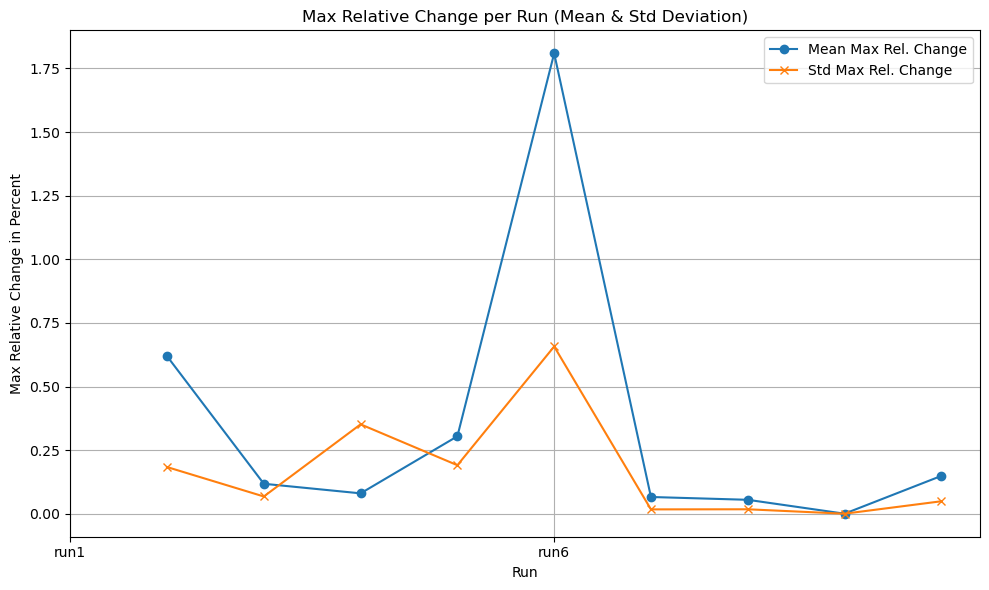

In [5]:
import matplotlib.pyplot as plt

# Step 1: Compute mean and std per run
columns = df.columns.drop(["household", "run"])  # Define the columns you want to use

# Initialize mean and std DataFrames with the correct columns
mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)

for i in range(1, df["run"].max() + 1):
    data_up_to_run = df[df["run"] <= i][columns]
    mean_df.loc[f"run{i}"] = data_up_to_run.mean()
    std_df.loc[f"run{i}"] = data_up_to_run.std()
# Step 2: Compute absolute relative change
mean_change = mean_df.pct_change().abs()

std_change = std_df.pct_change().abs() #(CurrentValue−PreviousValue)/PreviousValue
# Step 3: Add boolean where ALL column changes < threshold
threshold = 0.10

mean_change['max_relative_change'] = mean_change[columns].max(axis=1)
std_change['max_relative_change'] = std_change[columns].max(axis=1)
# Step 4: Combine both to find stabilization point
both_below = (mean_change['max_relative_change'] < threshold) & (std_change['max_relative_change'] < threshold)
stabilization_run = both_below[both_below].index[0] if both_below.any() else None

print(f"First run where ALL std and mean changes are < 10%: {stabilization_run}")

# Step 5: Plot max relative change per run for both mean and std
plt.figure(figsize=(10, 6))

plt.plot(mean_change.index, mean_change['max_relative_change'], marker='o', label='Mean Max Rel. Change')
plt.plot(std_change.index, std_change['max_relative_change'], marker='x', label='Std Max Rel. Change')

# Draw stabilization line
#if stabilization_run:
#    plt.axvline(x=stabilization_run, color='red', linestyle='--', label=f'Stabilized at {stabilization_run}')

plt.title('Max Relative Change per Run (Mean & Std Deviation)')
plt.xlabel('Run')
plt.ylabel('Max Relative Change in Percent')
xticks = mean_change.index
plt.xticks(ticks=xticks[::5])  # adjust ::5 to change frequency

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


First run where ALL std and mean changes are < 10.0%: run7


/scratch/local/9661272/ipykernel_1230509/374835044.py:31: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mean_change['max_col'] = mean_change[columns].idxmax(axis=1)
/scratch/local/9661272/ipykernel_1230509/374835044.py:35: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  std_change['max_col'] = std_change[columns].idxmax(axis=1)


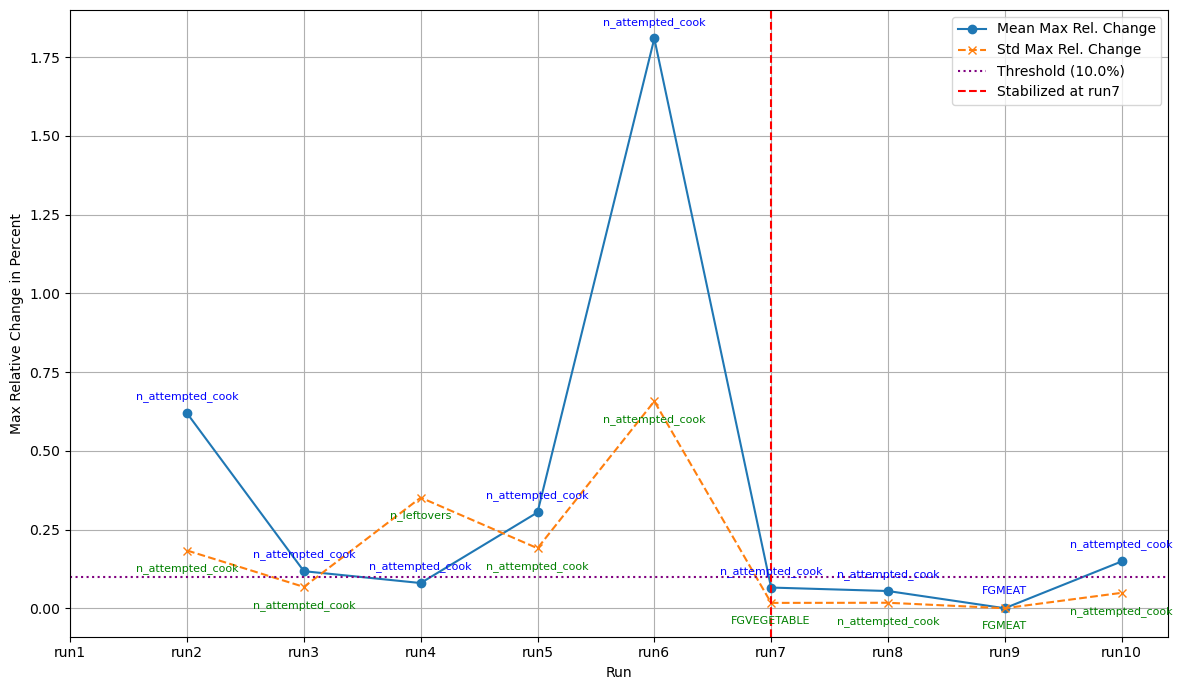

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Make sure numpy is imported if you're using it for other parts

# Assuming df is already defined and loaded with your data,
# for demonstration, I'll create a dummy df


# Step 1: Compute mean and std per run
columns = df.columns.drop(["household", "run"])  # Define the columns you want to use

# Initialize mean and std DataFrames with the correct columns
mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)

for i in range(1, df["run"].max() + 1):
    data_up_to_run = df[df["run"] <= i][columns]
    mean_df.loc[f"run{i}"] = data_up_to_run.mean()
    std_df.loc[f"run{i}"] = data_up_to_run.std()

# Step 2: Compute absolute relative change
mean_change = mean_df.pct_change().abs()
std_change = std_df.pct_change().abs()

# Step 3: Add boolean where ALL column changes < threshold
threshold = 0.10

# Store which column had the max change for annotation
mean_change['max_relative_change'] = mean_change[columns].max(axis=1)
# Find the column name corresponding to the max value for each row
mean_change['max_col'] = mean_change[columns].idxmax(axis=1)

std_change['max_relative_change'] = std_change[columns].max(axis=1)
# Find the column name corresponding to the max value for each row
std_change['max_col'] = std_change[columns].idxmax(axis=1)


# Step 4: Combine both to find stabilization point
both_below = (mean_change['max_relative_change'] < threshold) & \
             (std_change['max_relative_change'] < threshold)

stabilization_run = both_below[both_below].index[0] if both_below.any() else None

print(f"First run where ALL std and mean changes are < {threshold*100}%: {stabilization_run}")

# Step 5: Plot max relative change per run for both mean and std
plt.figure(figsize=(12, 7)) # Increased figure size for better label visibility

# Plot Mean Max Rel. Change
plt.plot(mean_change.index, mean_change['max_relative_change'], marker='o', label='Mean Max Rel. Change')
# Annotate mean data points with the column name that had the max change
for i, run_label in enumerate(mean_change.index):
    if pd.notna(mean_change.loc[run_label, 'max_relative_change']): # Ensure there's a value to plot
        plt.annotate(
            mean_change.loc[run_label, 'max_col'],
            (run_label, mean_change.loc[run_label, 'max_relative_change']),
            textcoords="offset points",
            xytext=(0, 10), # Offset text slightly above the point
            ha='center',
            fontsize=8,
            color='blue'
        )

# Plot Std Max Rel. Change
plt.plot(std_change.index, std_change['max_relative_change'], marker='x', label='Std Max Rel. Change', linestyle='--')
# Annotate std data points with the column name that had the max change
for i, run_label in enumerate(std_change.index):
    if pd.notna(std_change.loc[run_label, 'max_relative_change']): # Ensure there's a value to plot
        plt.annotate(
            std_change.loc[run_label, 'max_col'],
            (run_label, std_change.loc[run_label, 'max_relative_change']),
            textcoords="offset points",
            xytext=(0, -15), # Offset text slightly below the point
            ha='center',
            fontsize=8,
            color='green'
        )

# Draw stabilization threshold line
plt.axhline(y=threshold, color='purple', linestyle=':', label=f'Threshold ({threshold*100}%)')

# Draw stabilization line
if stabilization_run:
    plt.axvline(x=stabilization_run, color='red', linestyle='--', label=f'Stabilized at {stabilization_run}')

#plt.title('Max Relative Change per Run (Mean & Std Deviation) with Column Names')
plt.xlabel('Run')
plt.ylabel('Max Relative Change in Percent') # Removed "in Percent" as values are already fractional
xticks = mean_change.index
plt.xticks(ticks=xticks) # Show all run labels

plt.grid(True)
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [7]:
df.columns

Index(['household', 'FGMEAT', 'FGDAIRY', 'FGVEGETABLE', 'FGDRYFOOD',
       'FGSNACKS', 'FGBAKED', 'FGSTOREPREPARED', 'Inedible Parts',
       'Plate Waste', 'Spoiled Food', 'Prepared', 'Unprepared', 'Preprepared',
       'n_quickcook', 'n_cook', 'n_attempted_cook', 'n_leftovers', 'n_shop',
       'n_quickshop', 'n_attempted_shop', 'run'],
      dtype='object')

/scratch/local/9661272/ipykernel_1230509/1784810776.py:26: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mean_change['max_col'] = mean_change[columns].idxmax(axis=1)
/scratch/local/9661272/ipykernel_1230509/1784810776.py:29: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  std_change['max_col'] = std_change[columns].idxmax(axis=1)


First run where ALL mean/std changes are < 10.0%: run2
First run where ALL 95% CI widths are < 5.0% of their mean: None


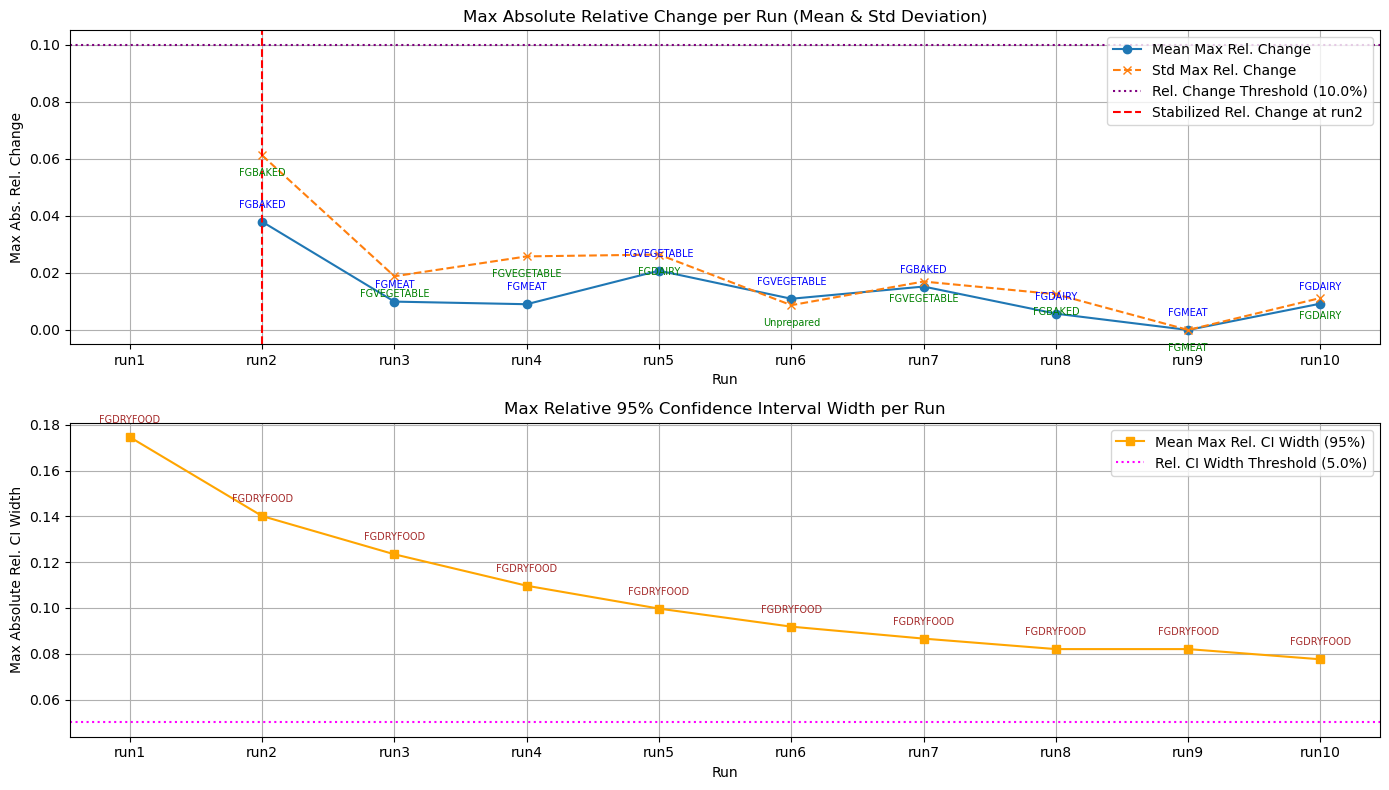

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats # For t-distribution

# Step 1: Compute mean, std, and count per run
columns = df.columns.drop(["household", "run",'n_quickcook', 'n_cook', 'n_attempted_cook', 'n_leftovers', 'n_shop',
    'n_quickshop', 'n_attempted_shop'])

mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)
count_df = pd.DataFrame(columns=columns) # To store N for SEM calculation

for i in range(1, df["run"].max() + 1):
    data_up_to_run = df[df["run"] <= i][columns]
    mean_df.loc[f"run{i}"] = data_up_to_run.mean()
    std_df.loc[f"run{i}"] = data_up_to_run.std()
    count_df.loc[f"run{i}"] = data_up_to_run.count() # Count of non-NaN values for each column

# Step 2: Compute absolute relative change (for mean and std stabilization as before)
mean_change = mean_df.pct_change().abs()
std_change = std_df.pct_change().abs()

# Store which column had the max change for annotation
mean_change['max_relative_change'] = mean_change[columns].max(axis=1)
mean_change['max_col'] = mean_change[columns].idxmax(axis=1)

std_change['max_relative_change'] = std_change[columns].max(axis=1)
std_change['max_col'] = std_change[columns].idxmax(axis=1)

# Step 3: Calculate 95% Confidence Interval Width for each feature's mean
confidence_level = 0.95
alpha = 1 - confidence_level

# Initialize DataFrame for CI width
ci_width_df = pd.DataFrame(columns=columns)

for run_label in mean_df.index:
    current_mean = mean_df.loc[run_label]
    current_std = std_df.loc[run_label]
    current_count = count_df.loc[run_label]

    ci_widths_for_run = pd.Series(index=columns, dtype=float)

    for col in columns:
        n = current_count[col]
        mean = current_mean[col]
        std = current_std[col]

        if n > 1 and pd.notna(std) and std != 0: # Need at least 2 data points for std and CI
            # Calculate Standard Error of the Mean (SEM)
            sem = std / np.sqrt(n)
            # Get the t-critical value
            degrees_freedom = n - 1
            t_critical = stats.t.ppf(1 - alpha / 2, degrees_freedom)
            # Calculate margin of error
            margin_of_error = t_critical * sem
            # CI width is 2 * margin_of_error
            ci_widths_for_run[col] = 2 * margin_of_error
        else:
            ci_widths_for_run[col] = np.nan # Cannot calculate CI for single or no data points, or zero std

    ci_width_df.loc[run_label] = ci_widths_for_run


# Step 4: Define stabilization for CI width
# We define CI stabilization when the CI width is below a certain percentage of the mean
# This is a relative threshold for CI stabilization
ci_width_relative_threshold = 0.05 # e.g., CI width should be less than 5% of the mean value

# Calculate relative CI width: CI_width / Mean
# Handle division by zero/NaN for means that are zero or NaN
relative_ci_width_df = (ci_width_df / mean_df.replace(0, np.nan)).abs() # Use .abs() just in case, replace 0 mean with NaN to avoid division by zero

relative_ci_width_df['max_relative_ci_width'] = relative_ci_width_df[columns].max(axis=1)
relative_ci_width_df['max_ci_col'] = relative_ci_width_df[columns].idxmax(axis=1)


# Step 5: Determine stabilization points
# Stabilization based on relative change of mean and std (as before)
change_threshold = 0.10 # Max relative change for mean/std to be below

both_below_change = (mean_change['max_relative_change'] < change_threshold) & \
                    (std_change['max_relative_change'] < change_threshold)
stabilization_run_change = both_below_change[both_below_change].index[0] if both_below_change.any() else None

# Stabilization based on CI width (new)
below_ci_threshold = (relative_ci_width_df['max_relative_ci_width'] < ci_width_relative_threshold)
stabilization_run_ci = below_ci_threshold[below_ci_threshold].index[0] if below_ci_threshold.any() else None

print(f"First run where ALL mean/std changes are < {change_threshold*100}%: {stabilization_run_change}")
print(f"First run where ALL 95% CI widths are < {ci_width_relative_threshold*100}% of their mean: {stabilization_run_ci}")


# Step 6: Plotting
plt.figure(figsize=(14, 8))

# --- Plot Max Relative Change (Mean & Std) ---
ax1 = plt.subplot(2, 1, 1) # Create a subplot for the first plot
ax1.plot(mean_change.index, mean_change['max_relative_change'], marker='o', label='Mean Max Rel. Change')
for i, run_label in enumerate(mean_change.index):
    if pd.notna(mean_change.loc[run_label, 'max_relative_change']):
        ax1.annotate(mean_change.loc[run_label, 'max_col'],
                    (run_label, mean_change.loc[run_label, 'max_relative_change']),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=7, color='blue')

ax1.plot(std_change.index, std_change['max_relative_change'], marker='x', label='Std Max Rel. Change', linestyle='--')
for i, run_label in enumerate(std_change.index):
    if pd.notna(std_change.loc[run_label, 'max_relative_change']):
        ax1.annotate(std_change.loc[run_label, 'max_col'],
                    (run_label, std_change.loc[run_label, 'max_relative_change']),
                    textcoords="offset points", xytext=(0, -15), ha='center', fontsize=7, color='green')

ax1.axhline(y=change_threshold, color='purple', linestyle=':', label=f'Rel. Change Threshold ({change_threshold*100}%)')
if stabilization_run_change:
    ax1.axvline(x=stabilization_run_change, color='red', linestyle='--', label=f'Stabilized Rel. Change at {stabilization_run_change}')

ax1.set_title('Max Absolute Relative Change per Run (Mean & Std Deviation)')
ax1.set_xlabel('Run')
ax1.set_ylabel('Max Abs. Rel. Change')
ax1.set_xticks(mean_change.index)
ax1.grid(True)
ax1.legend(loc='upper right')


# --- Plot Max Relative Confidence Interval Width ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1) # Share x-axis with the first subplot
ax2.plot(relative_ci_width_df.index, relative_ci_width_df['max_relative_ci_width'], marker='s', color='orange', label='Mean Max Rel. CI Width (95%)')
for i, run_label in enumerate(relative_ci_width_df.index):
    if pd.notna(relative_ci_width_df.loc[run_label, 'max_relative_ci_width']):
        ax2.annotate(relative_ci_width_df.loc[run_label, 'max_ci_col'],
                    (run_label, relative_ci_width_df.loc[run_label, 'max_relative_ci_width']),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=7, color='brown')

ax2.axhline(y=ci_width_relative_threshold, color='magenta', linestyle=':', label=f'Rel. CI Width Threshold ({ci_width_relative_threshold*100}%)')
if stabilization_run_ci:
    ax2.axvline(x=stabilization_run_ci, color='teal', linestyle='--', label=f'Stabilized CI Width at {stabilization_run_ci}')

ax2.set_title('Max Relative 95% Confidence Interval Width per Run')
ax2.set_xlabel('Run')
ax2.set_ylabel('Max Absolute Rel. CI Width')
ax2.set_xticks(relative_ci_width_df.index)
ax2.grid(True)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

/scratch/local/9661272/ipykernel_1230509/1808926819.py:42: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mean_change_pct['max_col'] = mean_change_pct[feature_columns].idxmax(axis=1)
/scratch/local/9661272/ipykernel_1230509/1808926819.py:45: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  std_change_pct['max_col'] = std_change_pct[feature_columns].idxmax(axis=1)


First run where ALL mean/std changes are < 10.0%: Run 2
First run where ALL 95% CI widths are < 5.0% of their mean: None


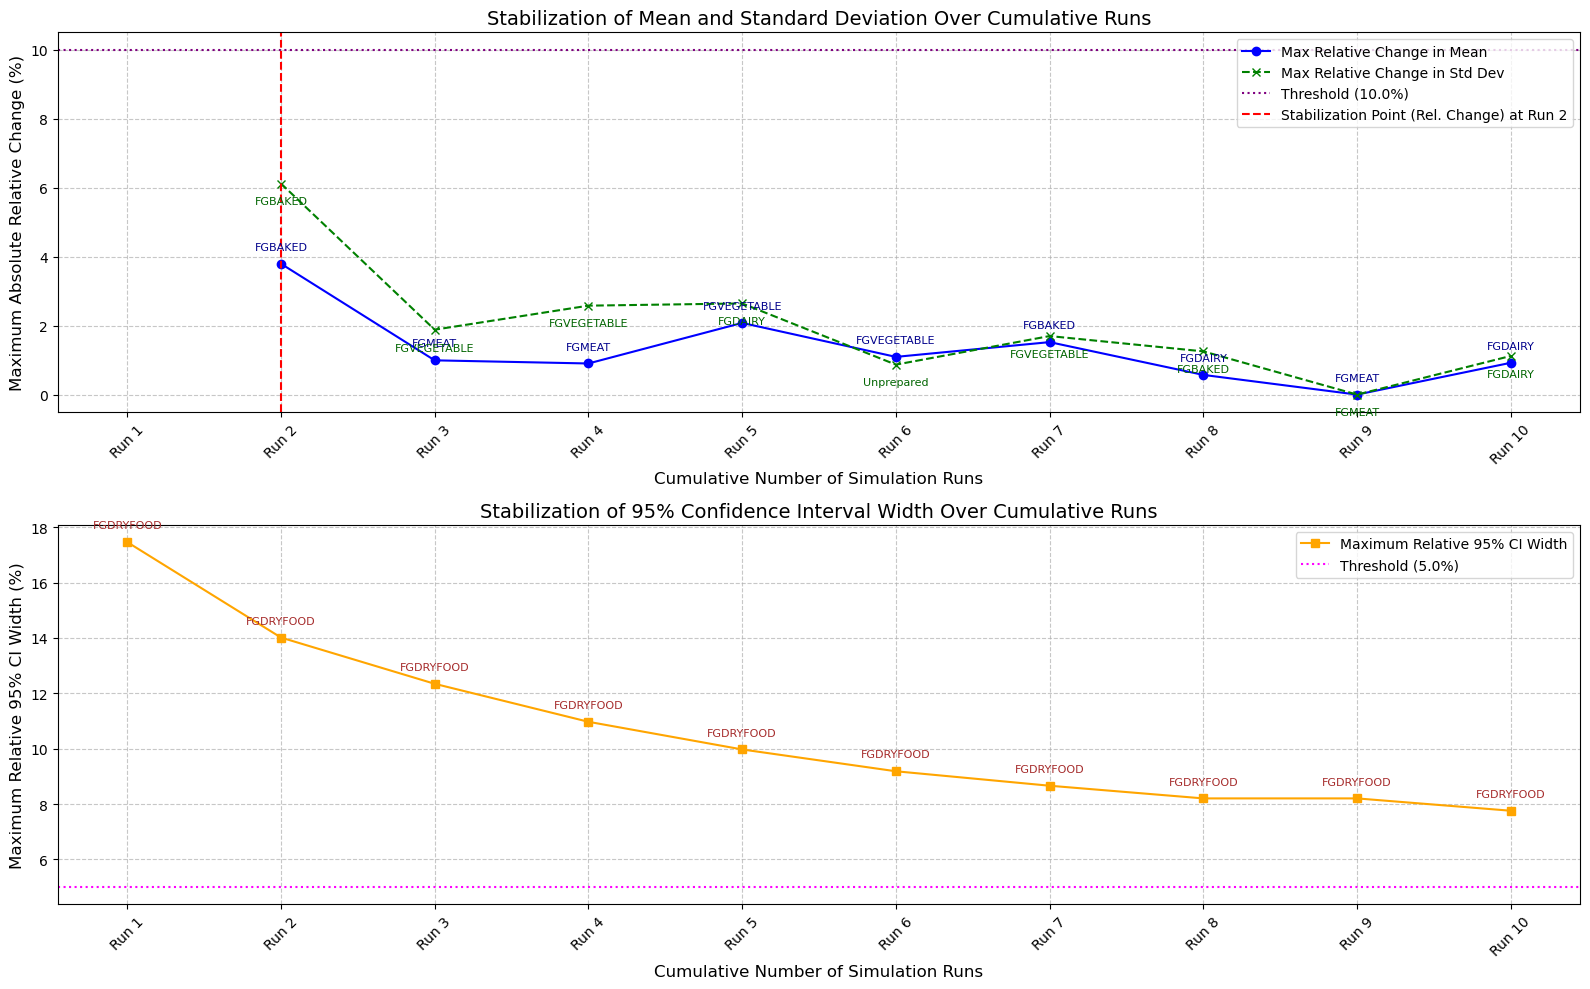

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats # For t-distribution

# --- Configuration Parameters (Easily adjustable at the top) ---
# Threshold for mean/std relative change to define stabilization (as a percentage)
MEAN_STD_CHANGE_THRESHOLD_PCT = 10.0
# Threshold for relative CI width to define stabilization (as a percentage)
CI_WIDTH_RELATIVE_THRESHOLD_PCT = 5.0
# Column names to exclude from feature analysis (if your df columns differ, adjust these)
EXCLUDE_COLUMNS = ["household", "run",'n_quickcook', 'n_cook', 'n_attempted_cook', 'n_leftovers', 'n_shop',
    'n_quickshop', 'n_attempted_shop']

# Convert percentage thresholds to decimals for internal calculations
change_threshold = MEAN_STD_CHANGE_THRESHOLD_PCT / 100.0
ci_width_relative_threshold = CI_WIDTH_RELATIVE_THRESHOLD_PCT / 100.0


# Step 1: Compute mean, std, and count per run (Cumulative)
# Trusting that df is already defined and working
feature_columns = df.columns.drop(EXCLUDE_COLUMNS)

mean_df = pd.DataFrame(columns=feature_columns)
std_df = pd.DataFrame(columns=feature_columns)
count_df = pd.DataFrame(columns=feature_columns) # To store N for SEM calculation

for i in range(1, df["run"].max() + 1):
    # Select data up to the current run 'i' for feature columns
    data_up_to_run = df[df["run"] <= i][feature_columns]
    mean_df.loc[f"Run {i}"] = data_up_to_run.mean()
    std_df.loc[f"Run {i}"] = data_up_to_run.std()
    count_df.loc[f"Run {i}"] = data_up_to_run.count() # Count of non-NaN values for each column

# Step 2: Compute absolute relative change (for mean and std stabilization)
# Calculate percentage change and take absolute value, then convert to percentage
mean_change_pct = mean_df.pct_change().abs() * 100
std_change_pct = std_df.pct_change().abs() * 100

# Store which column had the max change for annotation
mean_change_pct['max_relative_change'] = mean_change_pct[feature_columns].max(axis=1)
mean_change_pct['max_col'] = mean_change_pct[feature_columns].idxmax(axis=1)

std_change_pct['max_relative_change'] = std_change_pct[feature_columns].max(axis=1)
std_change_pct['max_col'] = std_change_pct[feature_columns].idxmax(axis=1)

# Step 3: Calculate 95% Confidence Interval Width for each feature's mean
confidence_level = 0.95
alpha = 1 - confidence_level

# Initialize DataFrame for CI width
ci_width_df = pd.DataFrame(columns=feature_columns)

for run_label in mean_df.index:
    current_mean = mean_df.loc[run_label]
    current_std = std_df.loc[run_label]
    current_count = count_df.loc[run_label]

    ci_widths_for_run = pd.Series(index=feature_columns, dtype=float)

    for col in feature_columns:
        n = current_count[col]
        mean = current_mean[col]
        std = current_std[col]

        # Need at least 2 data points for std and CI, and std must not be NaN or zero.
        # Handle cases where mean itself might be NaN.
        if pd.isna(mean) or pd.isna(std) or n < 2 or std == 0:
            ci_widths_for_run[col] = np.nan # Cannot calculate CI
        else:
            # Calculate Standard Error of the Mean (SEM)
            sem = std / np.sqrt(n)
            # Get the t-critical value
            degrees_freedom = n - 1
            t_critical = stats.t.ppf(1 - alpha / 2, degrees_freedom)
            # Calculate margin of error
            margin_of_error = t_critical * sem
            # CI width is 2 * margin_of_error
            ci_widths_for_run[col] = 2 * margin_of_error

    ci_width_df.loc[run_label] = ci_widths_for_run


# Step 4: Define stabilization for CI width
# Calculate relative CI width: CI_width / Mean, then convert to percentage
# Handle division by zero/NaN for means that are zero or NaN
relative_ci_width_pct_df = (ci_width_df / mean_df.replace(0, np.nan)).abs() * 100

relative_ci_width_pct_df['max_relative_ci_width'] = relative_ci_width_pct_df[feature_columns].max(axis=1)
relative_ci_width_pct_df['max_ci_col'] = relative_ci_width_pct_df[feature_columns].idxmax(axis=1)


# Step 5: Determine stabilization points
# Stabilization based on relative change of mean and std (as before)
# Compare the percentage values with the percentage thresholds
both_below_change = (mean_change_pct['max_relative_change'] < MEAN_STD_CHANGE_THRESHOLD_PCT) & \
                    (std_change_pct['max_relative_change'] < MEAN_STD_CHANGE_THRESHOLD_PCT)
stabilization_run_change = both_below_change[both_below_change].index[0] if both_below_change.any() else None

# Stabilization based on CI width (new)
below_ci_threshold = (relative_ci_width_pct_df['max_relative_ci_width'] < CI_WIDTH_RELATIVE_THRESHOLD_PCT)
stabilization_run_ci = below_ci_threshold[below_ci_threshold].index[0] if below_ci_threshold.any() else None

print(f"First run where ALL mean/std changes are < {MEAN_STD_CHANGE_THRESHOLD_PCT}%: {stabilization_run_change}")
print(f"First run where ALL 95% CI widths are < {CI_WIDTH_RELATIVE_THRESHOLD_PCT}% of their mean: {stabilization_run_ci}")


# Step 6: Plotting
plt.figure(figsize=(16, 10)) # Increased figure size for better readability

# --- Plot Max Relative Change (Mean & Std) ---
ax1 = plt.subplot(2, 1, 1) # Create a subplot for the first plot

ax1.plot(mean_change_pct.index, mean_change_pct['max_relative_change'],
         marker='o', label='Max Relative Change in Mean', color='blue')
# Annotate max_col for mean change with slight offset for clarity
for i, run_label in enumerate(mean_change_pct.index):
    if pd.notna(mean_change_pct.loc[run_label, 'max_relative_change']):
        ax1.annotate(mean_change_pct.loc[run_label, 'max_col'],
                     (run_label, mean_change_pct.loc[run_label, 'max_relative_change']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='darkblue')

ax1.plot(std_change_pct.index, std_change_pct['max_relative_change'],
         marker='x', label='Max Relative Change in Std Dev', linestyle='--', color='green')
# Annotate max_col for std change with slight offset for clarity
for i, run_label in enumerate(std_change_pct.index):
    if pd.notna(std_change_pct.loc[run_label, 'max_relative_change']):
        ax1.annotate(std_change_pct.loc[run_label, 'max_col'],
                     (run_label, std_change_pct.loc[run_label, 'max_relative_change']),
                     textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8, color='darkgreen')

ax1.axhline(y=MEAN_STD_CHANGE_THRESHOLD_PCT, color='purple', linestyle=':',
            label=f'Threshold ({MEAN_STD_CHANGE_THRESHOLD_PCT}%)')
if stabilization_run_change:
    ax1.axvline(x=stabilization_run_change, color='red', linestyle='--',
                label=f'Stabilization Point (Rel. Change) at {stabilization_run_change}', linewidth=1.5)

ax1.set_title('Stabilization of Mean and Standard Deviation Over Cumulative Runs', fontsize=14)
ax1.set_xlabel('Cumulative Number of Simulation Runs', fontsize=12) # Improved X-axis label
ax1.set_ylabel('Maximum Absolute Relative Change (%)', fontsize=12) # Improved Y-axis label
ax1.set_xticks(mean_change_pct.index)
ax1.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability
ax1.grid(True, linestyle='--', alpha=0.7) # Finer grid
ax1.legend(loc='upper right', fontsize=10)


# --- Plot Max Relative Confidence Interval Width ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1) # Share x-axis with the first subplot

ax2.plot(relative_ci_width_pct_df.index, relative_ci_width_pct_df['max_relative_ci_width'],
         marker='s', color='orange', label='Maximum Relative 95% CI Width')
# Annotate max_ci_col with slight offset for clarity
for i, run_label in enumerate(relative_ci_width_pct_df.index):
    if pd.notna(relative_ci_width_pct_df.loc[run_label, 'max_relative_ci_width']):
        ax2.annotate(relative_ci_width_pct_df.loc[run_label, 'max_ci_col'],
                     (run_label, relative_ci_width_pct_df.loc[run_label, 'max_relative_ci_width']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='brown')

ax2.axhline(y=CI_WIDTH_RELATIVE_THRESHOLD_PCT, color='magenta', linestyle=':',
            label=f'Threshold ({CI_WIDTH_RELATIVE_THRESHOLD_PCT}%)')
if stabilization_run_ci:
    ax2.axvline(x=stabilization_run_ci, color='teal', linestyle='--',
                label=f'Stabilization Point (CI Width) at {stabilization_run_ci}', linewidth=1.5)

ax2.set_title('Stabilization of 95% Confidence Interval Width Over Cumulative Runs', fontsize=14)
ax2.set_xlabel('Cumulative Number of Simulation Runs', fontsize=12) # Improved X-axis label
ax2.set_ylabel('Maximum Relative 95% CI Width (%)', fontsize=12) # Improved Y-axis label
ax2.set_xticks(relative_ci_width_pct_df.index)
ax2.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability
ax2.grid(True, linestyle='--', alpha=0.7) # Finer grid
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

95% CI Stabilization Run for each feature (threshold = 5.0% of mean):
- FGMEAT: Not Stabilized
- FGDAIRY: Not Stabilized
- FGVEGETABLE: Not Stabilized
- FGDRYFOOD: Not Stabilized
- FGSNACKS: Not Stabilized
- FGBAKED: Not Stabilized
- FGSTOREPREPARED: run6
- Inedible Parts: run7
- Plate Waste: run6
- Spoiled Food: Not Stabilized
- Prepared: Not Stabilized
- Unprepared: run7
- Preprepared: run6
- n_quickcook: Not Stabilized
- n_cook: run1
- n_attempted_cook: Not Stabilized
- n_leftovers: run1
- n_shop: Not Stabilized
- n_quickshop: run6
- n_attempted_shop: Not Stabilized


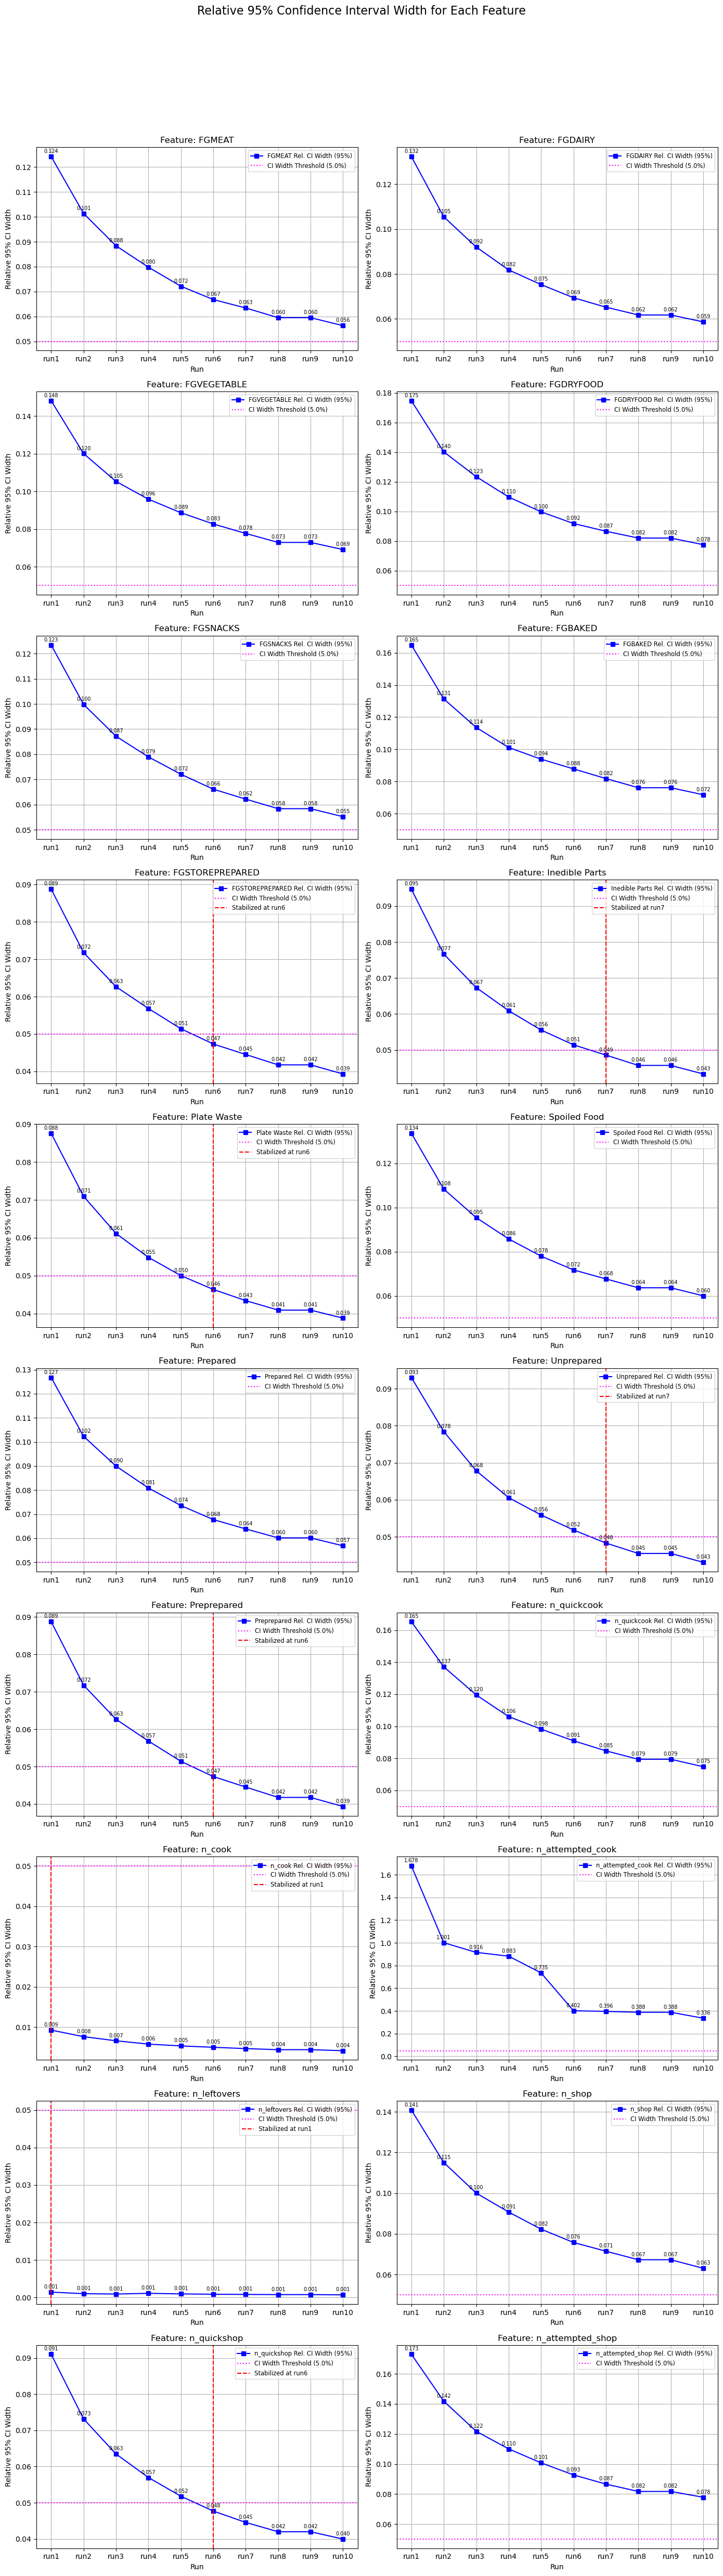

In [10]:


# Step 1: Compute mean, std, and count per run (cumulative)
columns = df.columns.drop(["household", "run"])

mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)
count_df = pd.DataFrame(columns=columns) # To store N for SEM calculation

for i in range(1, df["run"].max() + 1):
    data_up_to_run = df[df["run"] <= i][columns]
    mean_df.loc[f"run{i}"] = data_up_to_run.mean()
    std_df.loc[f"run{i}"] = data_up_to_run.std()
    count_df.loc[f"run{i}"] = data_up_to_run.count() # Count of non-NaN values for each column

# Step 2: Calculate 95% Confidence Interval Width for each feature's mean
confidence_level = 0.95
alpha = 1 - confidence_level

# Initialize DataFrame for CI width
ci_width_df = pd.DataFrame(columns=columns)

for run_label in mean_df.index:
    current_mean = mean_df.loc[run_label]
    current_std = std_df.loc[run_label]
    current_count = count_df.loc[run_label]

    ci_widths_for_run = pd.Series(index=columns, dtype=float)

    for col in columns:
        n = current_count[col]
        mean = current_mean[col]
        std = current_std[col]

        # Need at least 2 data points for std and CI calculation
        # Also check for std != 0 to prevent division by zero if std is perfectly 0
        if n > 1 and pd.notna(std) and std != 0:
            sem = std / np.sqrt(n)
            degrees_freedom = n - 1
            t_critical = stats.t.ppf(1 - alpha / 2, degrees_freedom)
            margin_of_error = t_critical * sem
            ci_widths_for_run[col] = 2 * margin_of_error
        else:
            ci_widths_for_run[col] = np.nan # Cannot calculate CI for single or no data points, or zero std

    ci_width_df.loc[run_label] = ci_widths_for_run


# Step 3: Define stabilization for CI width
# We define CI stabilization when the CI width is below a certain percentage of the mean
ci_width_relative_threshold = 0.05 # e.g., CI width should be less than 5% of the mean value

# Calculate relative CI width: CI_width / Mean
# Handle division by zero/NaN for means that are zero or NaN
relative_ci_width_df = (ci_width_df / mean_df.replace(0, np.nan)).abs()

# Step 4: Determine stabilization run for each feature based on CI width
stabilization_run_per_feature = {}
for col in columns:
    # Find the first run where the relative CI width for this column falls below the threshold
    stable_runs_for_col = relative_ci_width_df[col] < ci_width_relative_threshold
    first_stable_run = stable_runs_for_col[stable_runs_for_col].index
    if first_stable_run.any():
        stabilization_run_per_feature[col] = first_stable_run[0]
    else:
        stabilization_run_per_feature[col] = "Not Stabilized"

print(f"95% CI Stabilization Run for each feature (threshold = {ci_width_relative_threshold*100}% of mean):")
for feature, run in stabilization_run_per_feature.items():
    print(f"- {feature}: {run}")

# Step 5: Plotting each feature's Relative Confidence Interval Width
# Calculate number of rows and columns for subplots dynamically
n_features = len(columns)
n_cols = 2 # You can adjust this number
n_rows = (n_features + n_cols - 1) // n_cols # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows), squeeze=False)
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(columns):
    ax = axes[i]
    ax.plot(relative_ci_width_df.index, relative_ci_width_df[col], marker='s', color='blue', label=f'{col} Rel. CI Width (95%)')

    # Add annotations for each point
    for j, run_label in enumerate(relative_ci_width_df.index):
        value = relative_ci_width_df.loc[run_label, col]
        if pd.notna(value):
            ax.annotate(
                f'{value:.3f}', # Display the value, rounded to 2 decimal places
                (run_label, value),
                textcoords="offset points",
                xytext=(0, 5), # Offset text slightly above the point
                ha='center',
                fontsize=7,
                color='black'
            )

    ax.axhline(y=ci_width_relative_threshold, color='magenta', linestyle=':', label=f'CI Width Threshold ({ci_width_relative_threshold*100}%)')

    # Add stabilization line for this specific feature
    stable_run = stabilization_run_per_feature[col]
    if stable_run != "Not Stabilized":
        ax.axvline(x=stable_run, color='red', linestyle='--', label=f'Stabilized at {stable_run}')

    ax.set_title(f'Feature: {col}')
    ax.set_xlabel('Run')
    ax.set_ylabel('Relative 95% CI Width')
    ax.set_xticks(relative_ci_width_df.index)
    ax.grid(True)
    ax.legend(loc='upper right', fontsize='small')

# Hide any unused subplots if n_features is not a perfect multiple of n_cols
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Relative 95% Confidence Interval Width for Each Feature', y=1.02, fontsize=16) # Main title for all plots
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to make space for suptitle
plt.show()

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats # For t-distribution

# --- Configuration Parameters ---
# Column names to exclude from feature analysis (if your df columns differ, adjust these)
EXCLUDE_COLUMNS = ["household", "run"]
# Threshold for relative CI width to define stabilization (as a percentage)
CI_WIDTH_RELATIVE_THRESHOLD_PCT = 5.0

# Convert percentage threshold to decimal for internal calculations
ci_width_relative_threshold = CI_WIDTH_RELATIVE_THRESHOLD_PCT / 100.0


# Step 1: Compute mean, std, and count per run (cumulative)
# Trusting that df is already defined and working in your Jupyter Notebook
feature_columns = df.columns.drop(EXCLUDE_COLUMNS)

mean_df = pd.DataFrame(columns=feature_columns)
std_df = pd.DataFrame(columns=feature_columns)
count_df = pd.DataFrame(columns=feature_columns) # To store N for SEM calculation

for i in range(1, df["run"].max() + 1):
    # Select data up to the current run 'i' for feature columns
    data_up_to_run = df[df["run"] <= i][feature_columns]
    mean_df.loc[f"Run {i}"] = data_up_to_run.mean()
    std_df.loc[f"Run {i}"] = data_up_to_run.std()
    count_df.loc[f"Run {i}"] = data_up_to_run.count() # Count of non-NaN values for each column

# Step 2: Calculate 95% Confidence Interval Width for each feature's mean
confidence_level = 0.95
alpha = 1 - confidence_level

# Initialize DataFrame for CI width
ci_width_df = pd.DataFrame(columns=feature_columns)

for run_label in mean_df.index:
    current_mean = mean_df.loc[run_label]
    current_std = std_df.loc[run_label]
    current_count = count_df.loc[run_label]

    ci_widths_for_run = pd.Series(index=feature_columns, dtype=float)

    for col in feature_columns:
        n = current_count[col]
        mean = current_mean[col]
        std = current_std[col]

        # Need at least 2 data points for std and CI calculation
        # Also check for std != 0 to prevent division by zero if std is perfectly 0
        # And check if mean is not NaN
        if pd.isna(mean) or pd.isna(std) or n < 2 or std == 0:
            ci_widths_for_run[col] = np.nan # Cannot calculate CI
        else:
            # Calculate Standard Error of the Mean (SEM)
            sem = std / np.sqrt(n)
            # Get the t-critical value
            degrees_freedom = n - 1
            t_critical = stats.t.ppf(1 - alpha / 2, degrees_freedom)
            # Calculate margin of error
            margin_of_error = t_critical * sem
            # CI width is 2 * margin_of_error
            ci_widths_for_run[col] = 2 * margin_of_error

    ci_width_df.loc[run_label] = ci_widths_for_run


# Step 3: Define stabilization for CI width
# Calculate relative CI width: CI_width / Mean, then convert to percentage for plotting
# Handle division by zero/NaN for means that are zero or NaN
relative_ci_width_pct_df = (ci_width_df / mean_df.replace(0, np.nan)).abs() * 100

# Step 4: Determine stabilization run for each feature based on CI width
stabilization_run_per_feature = {}
for col in feature_columns:
    # Find the first run where the relative CI width for this column falls below the threshold (using decimal threshold)
    stable_runs_for_col = (relative_ci_width_pct_df[col] / 100) < ci_width_relative_threshold
    first_stable_run = stable_runs_for_col[stable_runs_for_col].index
    if first_stable_run.any():
        stabilization_run_per_feature[col] = first_stable_run[0]
    else:
        stabilization_run_per_feature[col] = "Not Stabilized"

print(f"95% CI Stabilization Run for each feature (threshold = {CI_WIDTH_RELATIVE_THRESHOLD_PCT}% of mean):")
for feature, run in stabilization_run_per_feature.items():
    print(f"- {feature}: {run}")


# Step 5: Plotting each feature's Relative Confidence Interval Width individually
for col in feature_columns:
    fig, ax = plt.subplots(figsize=(10, 6)) # Create a new figure for each feature

    # Plot the relative CI width for the current feature
    ax.plot(relative_ci_width_pct_df.index, relative_ci_width_pct_df[col],
            marker='s', color='blue', label=f'{col} Rel. CI Width (95%)')

    # Add annotations for each point
    for j, run_label in enumerate(relative_ci_width_pct_df.index):
        value = relative_ci_width_pct_df.loc[run_label, col]
        if pd.notna(value):
            ax.annotate(
                f'{value:.2f}%', # Display the value as percentage, rounded to 2 decimal places
                (run_label, value),
                textcoords="offset points",
                xytext=(0, 5), # Offset text slightly above the point
                ha='center',
                fontsize=8,
                color='black'
            )

    # Add the horizontal threshold line
    ax.axhline(y=CI_WIDTH_RELATIVE_THRESHOLD_PCT, color='magenta', linestyle=':',
               label=f'CI Width Threshold ({CI_WIDTH_RELATIVE_THRESHOLD_PCT}%)')

    # Add stabilization line for this specific feature if it stabilized
    stable_run = stabilization_run_per_feature[col]
    if stable_run != "Not Stabilized":
        ax.axvline(x=stable_run, color='red', linestyle='--',
                   label=f'Stabilized at {stable_run}', linewidth=1.5)

    # Set plot titles and labels for clarity
    ax.set_title(f'Relative 95% Confidence Interval Width for Feature: {col}', fontsize=14)
    ax.set_xlabel('Cumulative Number of Simulation Runs', fontsize=12)
    ax.set_ylabel('Relative 95% CI Width (%)', fontsize=12)
    ax.set_xticks(relative_ci_width_pct_df.index)
    ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right', fontsize=10)

    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # Save the plot with the specified filename format
    filename = f"sample_size_CI_width_{col}.png"
    plt.savefig(filename, bbox_inches='tight') # bbox_inches='tight' ensures all elements are saved

    plt.close(fig) # Close the figure to free up memory

print("\nIndividual plots generated and saved.")

95% CI Stabilization Run for each feature (threshold = 5.0% of mean):
- FGMEAT: Not Stabilized
- FGDAIRY: Not Stabilized
- FGVEGETABLE: Not Stabilized
- FGDRYFOOD: Not Stabilized
- FGSNACKS: Not Stabilized
- FGBAKED: Not Stabilized
- FGSTOREPREPARED: Run 6
- Inedible Parts: Run 7
- Plate Waste: Run 6
- Spoiled Food: Not Stabilized
- Prepared: Not Stabilized
- Unprepared: Run 7
- Preprepared: Run 6
- n_quickcook: Not Stabilized
- n_cook: Run 1
- n_attempted_cook: Not Stabilized
- n_leftovers: Run 1
- n_shop: Not Stabilized
- n_quickshop: Run 6
- n_attempted_shop: Not Stabilized



Individual plots generated and saved.


In [12]:
mean_change

,FGMEAT,FGDAIRY,FGVEGETABLE,FGDRYFOOD,FGSNACKS,FGBAKED,FGSTOREPREPARED,Inedible Parts,Plate Waste,Spoiled Food,Prepared,Unprepared,Preprepared,max_relative_change,max_col
run1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
run2,0.029016,0.026208,0.018456,0.037582,0.023826,0.037936,0.022821,0.018202,0.007779,0.036643,0.031104,0.012416,0.022821,0.037936,FGBAKED
run3,0.009931,0.006641,0.005926,0.001114,0.004260,0.001731,0.002783,0.000041,0.003628,0.004056,0.004638,0.003207,0.002783,0.009931,FGMEAT
run4,0.009019,0.005820,0.007806,0.002394,0.000809,0.005348,0.004157,0.003714,0.000249,0.000637,0.001117,0.002698,0.004157,0.009019,FGMEAT
run5,0.001105,0.018122,0.020778,0.010365,0.012461,0.019380,0.010290,0.003315,0.001193,0.006960,0.006803,0.015410,0.010290,0.020778,FGVEGETABLE
run6,0.004000,0.009680,0.010932,0.001894,0.003346,0.009591,0.009901,0.000002,0.001034,0.003101,0.003155,0.010420,0.009901,0.010932,FGVEGETABLE
run7,0.000829,0.005545,0.012789,0.000351,0.004148,0.015210,0.006446,0.003875,0.000176,0.000067,0.000440,0.005484,0.006446,0.015210,FGBAKED
run8,0.005550,0.005708,0.004490,0.004134,0.005378,0.000804,0.000700,0.003951,0.001258,0.005326,0.004954,0.001970,0.000700,0.005708,FGDAIRY
run9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,FGMEAT
run10,0.006264,0.009225,0.001892,0.005534,0.007488,0.001912,0.008462,0.001956,0.000964,0.007565,0.005532,0.002985,0.008462,0.009225,FGDAIRY


### Compare robustness between flexible max runs (n) and run intervals (m)

### TODO -> m indexing wrong here!

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
First run where ALL std and mean changes are < 10%: run12


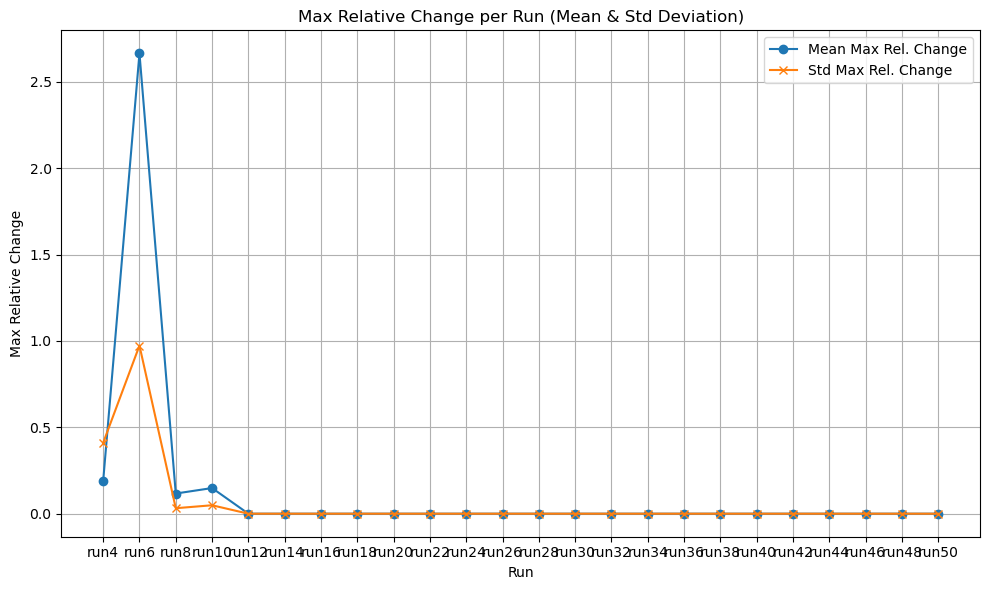

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the parameters
n = 50  # total number of runs
m = 2   # number of runs to skip between comparisons

# Define columns to use (excluding ID columns)
columns = df.columns.drop(["household", "run"])

# Step 1: Compute cumulative means and stds
mean_df = pd.DataFrame(columns=columns)
std_df = pd.DataFrame(columns=columns)

steps = list(range(m, n + 1, m)) 
print(steps)
for step in steps:
    subset = df[df["run"] <= step][columns]
    mean_df.loc[f"run{step}"] = subset.mean()
    std_df.loc[f"run{step}"] = subset.std()

# Step 2: Compute absolute relative change (manual, between cumulative windows)
mean_change = pd.DataFrame(columns=columns)
std_change = pd.DataFrame(columns=columns)

for i in range(1, len(steps)):
    prev_step = steps[i - 1]
    curr_step = steps[i]
    
    prev_mean = mean_df.loc[f"run{prev_step}"]
    curr_mean = mean_df.loc[f"run{curr_step}"]
    mean_change.loc[f"run{curr_step}"] = ((curr_mean - prev_mean) / prev_mean).abs()
    
    prev_std = std_df.loc[f"run{prev_step}"]
    curr_std = std_df.loc[f"run{curr_step}"]
    std_change.loc[f"run{curr_step}"] = ((curr_std - prev_std) / prev_std).abs()

# Step 3: Check for threshold stabilization
threshold = 0.10
mean_change["max_relative_change"] = mean_change.max(axis=1)
std_change["max_relative_change"] = std_change.max(axis=1)

both_below = (mean_change["max_relative_change"] < threshold) & (std_change["max_relative_change"] < threshold)
stabilization_run = both_below[both_below].index[0] if both_below.any() else None

print(f"First run where ALL std and mean changes are < 10%: {stabilization_run}")

# Step 4: Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_change.index, mean_change["max_relative_change"], marker='o', label='Mean Max Rel. Change')
plt.plot(std_change.index, std_change["max_relative_change"], marker='x', label='Std Max Rel. Change')

#if stabilization_run:
#    plt.axvline(x=stabilization_run, color='red', linestyle='--', label=f'Stabilized at {stabilization_run}')

plt.title('Max Relative Change per Run (Mean & Std Deviation)')
plt.xlabel('Run')
plt.ylabel('Max Relative Change')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
